In this notebook, we explore the model proposed by Mikolov et al. in [1]. We will build the Skipgram and CBOW models from scratch, train them on a relatively small corpus, and take a closer look at some analogies using these trained models. We will look at three different number of dimensions of the word embeddings in order to get a better intuition how the number of dimensions influences the result. The goal is not to obtain a high performance. Rather, the goal is to get a better understanding of the models. For that reason, Skipgram does not use negative sampling even though it would be used in practice.


[1] Mikolov, Tomas, et al. "Efficient Estimation of Word Representations in Vector Space" Advances in neural information processing systems. 2013.

In [1]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
import numpy as np
import keras.backend as K
import tensorflow as tf
import operator
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape, Lambda
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import sequence
from sklearn.metrics.pairwise import cosine_distances

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors as nn
from matplotlib import pylab
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import re
from sklearn.preprocessing import label_binarize

In [3]:
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Import file

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cd '/content/drive/MyDrive/Public/'

/content/drive/MyDrive/Public


In [6]:
file_name = 'corpus_penal.txt'
corpus = open(file_name).readlines()

### Data preprocessing


In [7]:
# Remove sentences with fewer than 3 words
corpus = [' '.join([word for word in sentence.split() if word not in stop_words]) for sentence in corpus]
corpus = [re.sub(r'\s+', ' ', sentence) for sentence in corpus]
corpus = [sentence for sentence in corpus if len(sentence.split()) >= 8]

# Remove punctuation in text and fit tokenizer on entire corpus
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"'")
tokenizer.fit_on_texts(corpus)

# Convert text to sequence of integer values
corpus = tokenizer.texts_to_sequences(corpus)
n_samples = sum(len(s) for s in corpus) # Total number of words in the corpus
V = len(tokenizer.word_index) + 1 # Total number of unique words in the corpus

In [8]:
n_samples, V

(92496, 10568)

In [9]:
# Example of how word to integer mapping looks like in the tokenizer
print(list((tokenizer.word_index.items()))[:5])

[('metropolitano', 1), ('art', 2), ('quito', 3), ('distrito', 4), ('el', 5)]


In [10]:
# Parameters
window_size = 2
window_size_corpus = 4

# Set numpy seed for reproducible results
np.random.seed(42)

## CBOW


In [11]:
from keras.preprocessing import sequence

# Prepare the data for the CBOW model
def generate_data_cbow(corpus, window_size, V):
    all_in = []
    all_out = []

    # Iterate over all sentences
    for sentence in corpus:
        L = len(sentence)
        for index, word in enumerate(sentence):
            start = index - window_size
            end = index + window_size + 1

            # Empty list which will store the context words
            context_words = []
            for i in range(start, end):
                # Skip the 'same' word
                if i != index:
                    # Add a word as a context word if it is within the window size
                    if 0 <= i < L:
                        context_words.append(sentence[i])
                    else:
                        # Pad with zero if there are no words
                        context_words.append(0)
            # Append the list with context words
            all_in.append(context_words)

            # Add one-hot encoding of the target word
            all_out.append(to_categorical(word, V))

    return (np.array(all_in), np.array(all_out))

For the CBOW model, we generate the training data differently compared to how we did it for the Skipgram model. With the CBOW model, we want to predict words based on their context. We do this by using a window around the word we want to predict. In our code, this window is represented by the `window_size`. All words contained in the window are the context words. Note that if we want to predict the first or final few words of a sentence (depends on the window size), it might be the case that our window reaches the previous or next sentence, respectively. In such a case, the window around the target word is restricted to the words that are in the same sentence. In the code, we solve this by using padding, which ensures that all sequences of context words the same length. For the padding, we simply use a value of 0.

In [12]:
# Create the training data
X_cbow, y_cbow = generate_data_cbow(corpus, window_size, V)
X_cbow.shape, y_cbow.shape

((92496, 4), (92496, 10568))

In [19]:
# Create the CBOW architecture
cbow_models = []
dims = [50]
for dim in dims:
    cbow = Sequential()

    # Add an Embedding layer
    cbow.add(Embedding(input_dim=V,
                       output_dim=dim,
                       input_length=window_size*2, # Note that we now have 2L words for each input entry
                       embeddings_initializer='glorot_uniform'))

    cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim, )))

    cbow.add(Dense(V, activation='softmax', kernel_initializer='glorot_uniform'))

    cbow.compile(optimizer=keras.optimizers.Adam(),loss='categorical_crossentropy',metrics=['accuracy'])


    cbow.summary()
    print("")
    cbow_models.append(cbow)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 4, 50)             528400    
                                                                 
 lambda_1 (Lambda)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 10568)             538968    
                                                                 
Total params: 1067368 (4.07 MB)
Trainable params: 1067368 (4.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



Again, we create a list for all the dimensions (50, 150, and 300). We iterate over this list and create models for each dimension.

Since we want to predict a target word using `window_size` $\cdot$ 2 context words, our `input_length` equals `window_size` $\cdot$ 2. Again, the input dimension simply equals the size of our vocabulary, namely `V`. The reasoning for this is analogous to the reasoning we provided for this matter when discussing the Skipgram model. This reasoning also applies to why we use Softmax and categorical cross-entropy. Furthermore, `adam` is used as our optimizer for the same reasons given in this section for the Skipgram model. Similar reasoning applies to why we use `glorot_uniform` initializers.

In [20]:
# Train CBOW model
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_cbow, y_cbow, test_size=0.2, random_state=42)

#for cbow in cbow_models:
#    history  = cbow.fit(X_cbow, y_cbow, batch_size=64, epochs=50, verbose=1)
#    print("")

for cbow in cbow_models:
    history = cbow.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=50, verbose=1)
    print("")


Epoch 1/50
1157/1157 [==============================] - 14s 11ms/step - loss: 8.0992 - accuracy: 0.0298 - val_loss: 7.7876 - val_accuracy: 0.0341
Epoch 2/50
1157/1157 [==============================] - 8s 7ms/step - loss: 7.5000 - accuracy: 0.0480 - val_loss: 7.6580 - val_accuracy: 0.0503
Epoch 3/50
1157/1157 [==============================] - 8s 7ms/step - loss: 7.2613 - accuracy: 0.0639 - val_loss: 7.5042 - val_accuracy: 0.0734
Epoch 4/50
1157/1157 [==============================] - 7s 6ms/step - loss: 6.9788 - accuracy: 0.0838 - val_loss: 7.3021 - val_accuracy: 0.0917
Epoch 5/50
1157/1157 [==============================] - 7s 6ms/step - loss: 6.6561 - accuracy: 0.1086 - val_loss: 7.0845 - val_accuracy: 0.1105
Epoch 6/50
1157/1157 [==============================] - 7s 6ms/step - loss: 6.3174 - accuracy: 0.1329 - val_loss: 6.8875 - val_accuracy: 0.1288
Epoch 7/50
1157/1157 [==============================] - 7s 6ms/step - loss: 5.9959 - accuracy: 0.1546 - val_loss: 6.7254 - val_accurac

**Motivation**. The motivation for training the CBOW models the way we do is equivalent to the motivation given for training the Skipgram models. The only difference between these models and the Skipgram models is that, for these models, we can still see the accuracy increase and loss decrease after several epochs, while this was not the case for the Skipgram models. This is one of the reasons why we train CBOW for more epochs than Skipgram. Furthermore, we can easily increase the number of epochs for these models compared to the ones for Skipgram since CBOW is significantly faster to train than Skipgram. The results of this model together with the Skipgram model will explored further in Task 1.3.

In [21]:
for cbow in cbow_models:
    # Save embeddings for vectors of length 50, 150 and 300 using cbow model
    weights = cbow.get_weights()

    # Get the embedding matrix
    embedding = weights[0]

    # Get word embeddings for each word in the vocabulary, write to file
    f = open(f'vectors_cbow_{len(embedding[0])}.txt', 'w')

    # Create columns for the words and the values in the matrix, makes it easier to read as dataframe
    columns = ["word"] + [f"value_{i+1}" for i in range(embedding.shape[1])]

    # Start writing to the file, start with the column names
    f.write(" ".join(columns))
    f.write("\n")

    for word, i in tokenizer.word_index.items():
        f.write(word)
        f.write(" ")
        f.write(" ".join(map(str, list(embedding[i,:]))))
        f.write("\n")
    f.close()

In [22]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Pérdida en Entrenamiento')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Pérdida en Validación')
    else:
        print("Advertencia: No se encontró 'val_loss' en el historial.")
    plt.title('Pérdida Durante Entrenamiento y Validación')
    plt.xlabel('Época')
    plt.ylabel('Pérdida (Categorical Crossentropy)')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Precisión en Entrenamiento')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Precisión en Validación')
    else:
        print("Advertencia: No se encontró 'val_accuracy' en el historial.")
    plt.title('Precisión Durante Entrenamiento y Validación')
    plt.xlabel('Época')
    plt.ylabel('Precisión (Proporción)')
    plt.legend()
    plt.grid(True)
    plt.show()



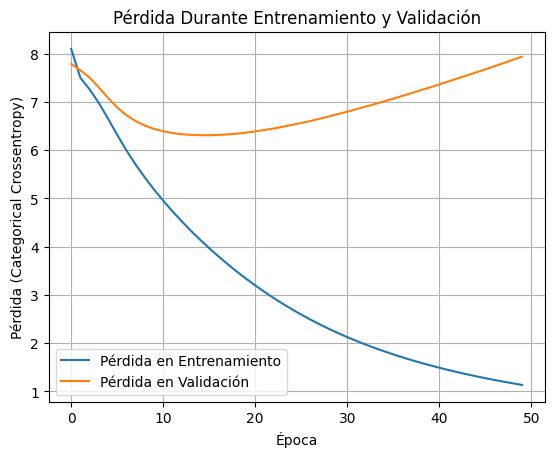

In [23]:
plot_loss(history)


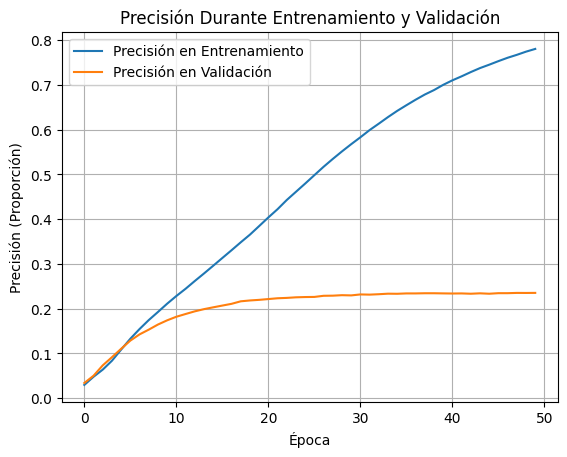

In [24]:
plot_accuracy(history)

## Analogy function

Let us implement our own function to perform the analogy task. We will use the same distance metric as in [1]. With this function, we want to be able to answer whether an analogy like: "a king is to a queen as a man is to a woman" ($e_{king} - e_{queen} + e_{woman} \approx e_{man}$) is true. In a perfect scenario, we would like that this analogy ($e_{king} - e_{queen} + e_{woman}$) results in the embedding of the word "man". However, it does not always result in exactly the same word embedding. In this context, we will call "man" the true or the actual word $t$. We want to find the word $p$ in the vocabulary, where the embedding of $p$ ($e_p$) is the closest to the predicted embedding (i.e., the result of the formula). Then, we can check if $p$ is the same word as the true word $t$.  

### Computing the distance between the predicted and true word

In [25]:
def embed(word, embedding, vocab_size=V, tokenizer=tokenizer):
    """ Embed a word by getting the one hot encoding and taking the dot product of this vector with the
        embedding matrix 'word' = string type
    """
    # get the index of the word from the tokenizer, i.e. convert the string to it's corresponding integer in the vocabulary
    int_word = tokenizer.texts_to_sequences([word])[0]
    # get the one-hot encoding of the word
    bin_word = to_categorical(int_word, V)
    return np.dot(bin_word, embedding)

In [26]:
def compute_distance(word_a, word_b, word_c, word_d):
    """ Returns the cosine distance between the predicted and the true word (word_d)

    Our analogy function is: 'word_a is to word_b as word_c is to ?'
    Here, ? is predicted based on the embeddings. Then, we compare ? to word_d, which is the true word.
    """
    models = cbow_models
    embeddings = [model.get_weights()[0] for model in models]
    for embedding in embeddings:
        predicted_embedding = embed(word_b, embedding) - embed(word_a, embedding) + embed(word_c, embedding)
        dist_exp_true = cosine_distances(predicted_embedding, embed(word_d, embedding))
        print(dist_exp_true[0][0])

In [27]:
# Example distances between the predicted and true word for skipgram 50, 100, 150, and cbow 50, 100, 150
compute_distance('sentencia','auto', 'delito', 'art')

0.9808958


### Listing the top $z$ closest words based on an analogy function

In [28]:
from scipy.spatial.distance import cosine, cdist


def embed(word, embedding, vocab_size=V, tokenizer=tokenizer):
    # Get the index of the word from the tokenizer, i.e. convert the string to it's corresponding integer in the vocabulary
    int_word = tokenizer.texts_to_sequences([word])[0]
    # Get the one-hot encoding of the word
    bin_word = to_categorical(int_word, V)
    return np.dot(bin_word, embedding).reshape(-1)


def get_nearest_words(model_name, embed_word, used_words, nr=10):
    """Returns the `nr` nearest words to the `embed_word` for a certain `model_name`
    """
    # Load the model embedding matrix and create a list of all the words
    df = pd.read_csv(f"vectors_{model_name}.txt", sep=" ")

    # Filter out words that are in the analogy
    df = df[~(df["word"].isin(used_words))]

    # Store the embedded representation of the words
    embedded_words = df.iloc[:, 1:].values
    embedded_word = embed_word.reshape(1, -1)

    # Get the distances between the input embedding and the embedded words such that we can look for the smallest one
    # cdist makes it easy for us to compute the cosine distance between each pair of the two collections of inputs
    distances = cdist(embedded_word, embedded_words, "cosine").reshape(-1)

    # Sort distances and store the indices of the `nr` lowest distances
    top_sorted_indices = distances.argsort()[:nr]

    # Convert the indices to actual words
    top_words = [list(df["word"])[i] for i in top_sorted_indices]

    # Keep the rounded values of those indices
    values = [round(distances[i], 4) for i in top_sorted_indices]
    # Concatenate the top words together with their values and return it as a list
    return list(zip(top_words, values))

def close_words(model, word, tokenizer, nr=10):
    """Devuelve las `nr` palabras más cercanas a la `word` en el modelo proporcionado."""
    # Obtener el embedding del modelo
    embedding = model.get_weights()[0]
    # Obtener el embedding de la palabra objetivo
    word_embedding = embeded_word(word, embedding, len(tokenizer.word_index) + 1, tokenizer).reshape(1, -1)

    # Obtener todos los embeddings de palabras
    all_embeddings = embedding

    # Calcular las distancias coseno entre el embedding de la palabra y todos los demás embeddings
    distances = cosine_distances(word_embedding, all_embeddings).reshape(-1)

    # Obtener los índices de las palabras más cercanas
    nearest_indices = distances.argsort()[:nr + 1]  # +1 porque la palabra en sí misma estará incluida

    # Obtener las palabras y distancias correspondientes
    nearest_words = [(tokenizer.index_word[idx], distances[idx]) for idx in nearest_indices if idx != tokenizer.word_index[word]]

    return nearest_words[:nr]

def embeded_word(word, embedding, vocab_size, tokenizer):
    # Obtener el índice de la palabra del tokenizer
    int_word = tokenizer.texts_to_sequences([word])[0]
    # Obtener el embedding de la palabra
    word_embedding = embedding[int_word]
    return word_embedding

def print_analogy(analogy, embeddings, models, model_names, nr=10):
    # Retrieve the words from the analogy we need to compute
    word_a, word_b, word_c, word_true = analogy

    # Formulate the analogy task
    analogy_task = f"{word_a} is to {word_b} as {word_c} is to ?"

    print(f"Analogy Task: {analogy_task}")
    print("---------------------------------------------------")

    # Iterate over all models available
    for model_name, embedding in zip(model_names, embeddings):
        # Obtain embeddings for all the words
        embed_true = embed(word_true, embedding)
        embed_a, embed_b, embed_c = embed(word_a, embedding), embed(word_b, embedding), embed(word_c, embedding)

        # Obtain the predicted embedding based on the analogy function
        embed_prediction = embed_b - embed_a + embed_c

        # The true word with distance similarity value between predicted embedding and true word embedding,
        # also denoted `sim1` in the text above
        sim1 = round(cosine(embed_true, embed_prediction), 4)

        # The predicted word with distance similarity value between predicted embedding and the embedding of the word
        # in the vocabulary that is closest to this predicted embedding
        word_prediction, sim2 = get_nearest_words(model_name, embed_prediction, [word_a, word_b, word_c], 1)[0]

        # Get the top `nr` nearest words
        nearest_words = get_nearest_words(model_name, embed_prediction, [word_a, word_b, word_c], nr)

        # Print whether or not the true word was in the top nr
        partially_correct = word_true in [word[0] for word in nearest_words]

        print(f"Embedding: {model_name}")
        # Print all top nr words with their distance
        for word in nearest_words:
            print(f"{word[0]} => {round(word[1], 4)}")
        print(f"Predicted: {word_prediction} ({round(sim2, 4)}) - True: {word_true} ({sim1})")
        print(f"Correct? {word_prediction == word_true} - In the top {nr}? {partially_correct}")
        print("---------------------------------------------------")

In [29]:
# Concatenate all models such that we can easily iterate over all models
models = cbow_models

# Store the embeddings of all models such that we can easily iterate over them
word_embeddings = [model.get_weights()[0] for model in models]

# Store the model names such that we can easily iterate over them
model_names = ["cbow_50"]

# Set the number of top words to print
nr = 10

print_analogy(analogy=('ley', 'sentencia', 'delito', 'robo'), embeddings=word_embeddings, models=models, model_names=model_names, nr=nr)

Analogy Task: ley is to sentencia as delito is to ?
---------------------------------------------------
Embedding: cbow_50
escándalos => 0.5056
desórdenes => 0.5446
retroalimenta => 0.556
per => 0.5611
debía => 0.5655
constaba => 0.5801
ninguna => 0.5893
fin => 0.592
motivadas => 0.5953
gómez => 0.5967
Predicted: escándalos (0.5056) - True: robo (0.9411)
Correct? False - In the top 10? False
---------------------------------------------------


In [30]:
word_to_find = "sentencia"
nearest_words = close_words(cbow, word_to_find, tokenizer, nr=10)
print(f"Palabras más cercanas a '{word_to_find}':")
for word, distance in nearest_words:
    print(f"{word}: {distance:.4f}")

Palabras más cercanas a 'sentencia':
per: 0.3202
prevaleciendo: 0.4559
regir: 0.4807
hace: 0.5047
19: 0.5074
nece: 0.5174
tratándose: 0.5178
80: 0.5245
sectorial: 0.5252
ejecutoriada: 0.5257


In [31]:
word_to_find = "auto"
nearest_words = close_words(cbow, word_to_find, tokenizer, nr=10)
print(f"Palabras más cercanas a '{word_to_find}':")
for word, distance in nearest_words:
    print(f"{word}: {distance:.4f}")

Palabras más cercanas a 'auto':
emitirse: 0.4880
promesa: 0.4917
nuevamente: 0.5103
da: 0.5130
1651: 0.5236
semestres: 0.5295
publicado: 0.5327
opte: 0.5366
1341: 0.5380
una: 0.5405


In [32]:
word_to_find = "dolo"
nearest_words = close_words(cbow, word_to_find, tokenizer, nr=10)
print(f"Palabras más cercanas a '{word_to_find}':")
for word, distance in nearest_words:
    print(f"{word}: {distance:.4f}")

Palabras más cercanas a 'dolo':
culpa: 0.3685
1907: 0.4288
1153: 0.4294
1273: 0.4350
934: 0.4410
1861: 0.4549
constatación: 0.4691
vencida: 0.4703
1521: 0.4717
1872: 0.4722


In [33]:
word_to_find = "crimen"
nearest_words = close_words(cbow, word_to_find, tokenizer, nr=10)
print(f"Palabras más cercanas a '{word_to_find}':")
for word, distance in nearest_words:
    print(f"{word}: {distance:.4f}")

Palabras más cercanas a 'crimen':
nulla: 0.3461
sine: 0.3848
montealegre: 0.4030
bernal: 0.4052
legados: 0.4489
jaime: 0.4553
modas: 0.4602
cuellar: 0.4842
edgar: 0.5062
chaparro: 0.5224


In [34]:
word_to_find = "nulidad"
nearest_words = close_words(cbow, word_to_find, tokenizer, nr=10)
print(f"Palabras más cercanas a '{word_to_find}':")
for word, distance in nearest_words:
    print(f"{word}: {distance:.4f}")

Palabras más cercanas a 'nulidad':
cosa: 0.3721
“efecto: 0.4150
“artículo: 0.4268
esquema: 0.4592
antijurídica: 0.4750
sobreseimiento: 0.4834
personalmente: 0.4915
cabanellas: 0.4986
cuantitativa: 0.5210
falsa: 0.5221


In [35]:
word_to_find = "coip"
nearest_words = close_words(cbow, word_to_find, tokenizer, nr=10)
print(f"Palabras más cercanas a '{word_to_find}':")
for word, distance in nearest_words:
    print(f"{word}: {distance:.4f}")

Palabras más cercanas a 'coip':
600: 0.4148
566: 0.4206
continuado: 0.4833
632: 0.5061
916: 0.5130
624: 0.5133
ibídem: 0.5177
225: 0.5330
hechos: 0.5429
411: 0.5443


In [36]:
word_to_find = "maltrato"
nearest_words = close_words(cbow, word_to_find, tokenizer, nr=10)
print(f"Palabras más cercanas a '{word_to_find}':")
for word, distance in nearest_words:
    print(f"{word}: {distance:.4f}")

Palabras más cercanas a 'maltrato':
930: 0.4932
eliminación: 0.4951
sida: 0.4992
implementados: 0.5007
asociatividad: 0.5069
1857: 0.5319
patrocinar: 0.5356
j: 0.5373
81: 0.5418
diversidad: 0.5442


In [37]:
word_to_find = "articulo"
nearest_words = close_words(cbow, word_to_find, tokenizer, nr=10)
print(f"Palabras más cercanas a '{word_to_find}':")
for word, distance in nearest_words:
    print(f"{word}: {distance:.4f}")

Palabras más cercanas a 'articulo':
notas: 0.3851
art: 0.5092
correrá: 0.5148
1566: 0.5257
juan: 0.5366
2: 0.5487
1: 0.5562
oralidad: 0.5723
perros: 0.5724
adaptará: 0.5727


In [38]:
word_to_find = "derecho"
nearest_words = close_words(cbow, word_to_find, tokenizer, nr=10)
print(f"Palabras más cercanas a '{word_to_find}':")
for word, distance in nearest_words:
    print(f"{word}: {distance:.4f}")

Palabras más cercanas a 'derecho':
comparecencia: 0.4662
óptimos: 0.5179
vis: 0.5180
amplia: 0.5400
documento: 0.5437
justificable: 0.5466
justicia: 0.5480
absuelto: 0.5484
servidora: 0.5698
duelo: 0.5699
